In [1]:
import numpy as np
from sklearn import preprocessing
import pandas
from matplotlib import pyplot
import matplotlib

import podomics

## Loading a dataset

In [2]:
omics = podomics.read_csv("examples/exampledata3.csv", sample="Sample", time="Timepoint", condition="Condition")
display(omics.data)
print("Timepoints:", omics.timepoints)

,Condition,Timepoint,10,43,2,0,16,30,33,48,...,21,45,36,32,19,35,5,4,26,20
Sample,,,,,,,,,,,,,,,,,,,,,
aT0R0,a,0.00,0.294415,0.012780,0.988288,1.000774,0.070487,0.033389,0.097109,0.042608,...,0.115557,0.062764,0.059689,0.001347,0.039318,0.067885,0.734178,0.778521,0.068821,0.066999
aT0R2,a,0.00,0.293859,0.006343,0.922625,1.059388,0.145908,0.014464,0.002039,0.020438,...,0.079815,0.023210,0.018816,0.046768,0.054146,0.031905,0.888025,0.933068,0.031893,0.045568
aT0R1,a,0.00,0.351795,0.010958,0.982960,1.008382,0.029968,0.050681,0.021210,0.038401,...,0.033762,0.090298,0.034470,0.013217,0.073380,0.014011,0.827395,0.812171,0.075668,0.058851
aT1R0,a,0.25,0.307706,0.132628,0.776740,0.807937,0.109115,0.033649,0.012068,0.241186,...,0.036998,0.214621,0.086361,0.017612,0.106503,0.071145,0.567324,0.657356,0.025611,0.020685
aT1R2,a,0.25,0.304130,0.146054,0.739624,0.813807,0.067468,0.055404,0.054312,0.211041,...,0.048538,0.170014,0.063979,0.024221,0.078149,0.037396,0.583339,0.749517,0.036451,0.045039
aT1R1,a,0.25,0.275352,0.159591,0.742667,0.875218,0.084458,0.057129,0.066403,0.191626,...,0.066859,0.234537,0.044267,0.081364,0.060844,0.047234,0.554243,0.694851,0.047123,0.024907
aT2R2,a,0.50,0.282066,0.256283,0.587074,0.587388,0.040291,0.023810,0.034990,0.476731,...,0.020056,0.327235,0.111029,0.040182,0.090013,0.097243,0.503968,0.478187,0.017447,0.029998
aT2R1,a,0.50,0.177077,0.269734,0.608791,0.595784,0.070523,0.051333,0.041980,0.394384,...,0.082593,0.358423,0.066623,0.021845,0.006668,0.063426,0.468577,0.556685,0.025724,0.029887
aT2R0,a,0.50,0.271157,0.290063,0.610354,0.645140,0.079351,0.046650,0.030509,0.411612,...,0.048475,0.312657,0.067804,0.025866,0.074340,0.024579,0.482949,0.511908,0.031091,0.073425


Timepoints: [0.   0.25 0.5  0.75 1.  ]


## Data rescaling

The recommended way to rescale the data is to divide each feature by a typical value, for example its maximum or median value. A good alternative can be a log-scaling. The implementations of these methods is illustrated below.

z-score normalization or similar is not recommended, since it removes difference in variance among features that may contain relevant timeseries information.

### Scaling by maximum value

Scaling with maximum value is the default in podomics and can be achieved by calling the `rescale()` method without any parameters.

In [3]:
omics_maxscaled = omics.rescale()
np.array([omics_maxscaled.data[f].max() for f in omics_maxscaled.features])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The output shows that all features in the rescaled dataset have a maximum value of 1.

### Scaling by median

Unfortunately there is now median scaler in the `sklearn.preprocessing` currently. We provide a custom `MedianScaler` class in the `dataset` module, that closely follows the implementation of the `MaxAbsScaler` class.

An instance of the `MedianScaler` class has to be passed to the `rescale()` method to do a scaling wit the median.

In [4]:
omics_medscaled = omics.rescale(method=podomics.dataset.MedianScaler())
np.array([omics_medscaled.data[f].median() for f in omics_medscaled.features])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The output shows that all features in the rescaled dataset have a median value of 1.

### Log scaling

TODO, use sklearn.preprocessing.FunctionTransformer

## Data plotting

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Condition a'}, xlabel='Feature index', ylabel='Feature values'>,
        <AxesSubplot: title={'center': 'Condition b'}, xlabel='Feature index'>],
       dtype=object))

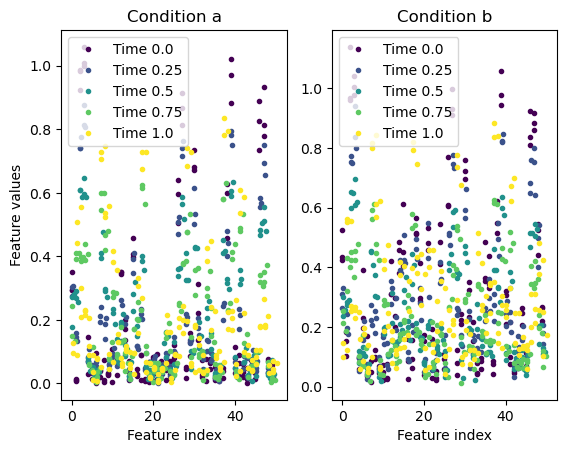

In [5]:
omics.plot(condition=["a", "b"])

Text(0.5, 1.0, 'Median scaled data - a')

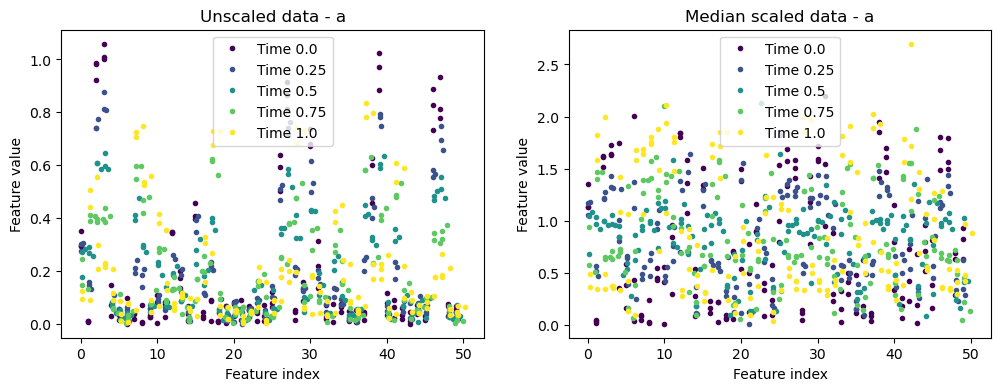

In [6]:
fig, axs = pyplot.subplots(1, 2, figsize=(12, 4))
omics.plot(ax=axs[0], condition="a")
omics_medscaled.plot(ax=axs[1], condition="a")
for ax in axs:
    ax.set_xlabel("Feature index")
    ax.set_ylabel("Feature value")
axs[0].set_title("Unscaled data - a")
axs[1].set_title("Median scaled data - a")